In [360]:
import numpy as np
import pandas as pd

In [361]:
dfAdmissions = pd.read_csv("../data/ADMISSIONS.csv")

dfDiagnoses = pd.read_csv("../data/DIAGNOSES_ICD.csv")

dfTitle = pd.read_csv("../data/d_icd_diagnoses.csv")

df = pd.merge(dfAdmissions, dfDiagnoses, how="inner", on=['SUBJECT_ID'])

#

#drop na values
df = df.dropna()

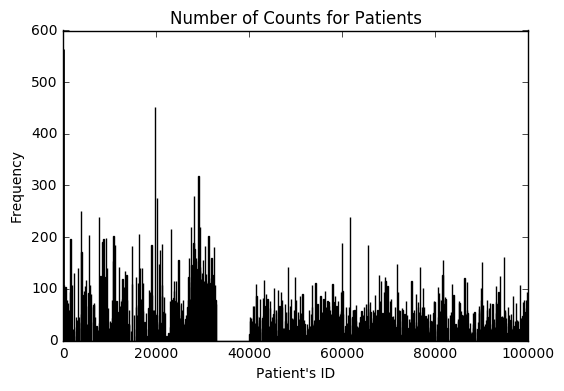

(55196, 23)

In [363]:
import matplotlib.pyplot as plt

plt.hist(df['SUBJECT_ID'] ,bins=2053)
plt.title("Number of Counts for Patients")
plt.xlabel("Patient's ID")
plt.ylabel("Frequency")

plt.show()

df.shape

In [364]:
#creating vector of HAI related to pneumonia, and HAP

hcapCode = ["48230","48231","48232","48233", "48234", "48235", "48236", "48237", "48238", 
            "48239", "48240", "4830", "4822", "4820", "48240", "48241", "48242", "48243",
           "48244", "48245", "48246", "48247", "48248", "48249", "48282", "48281", "48283",
           "48284", "48289"]

#creating boolean values that are HAI related to pneumonia, and HAP
df['is_it_HAI'] = df['ICD9_CODE'].map(lambda x: any(x == i for i in hcapCode)) 

## Total number of HAIs cases

In [365]:
len(df['SUBJECT_ID'][df['is_it_HAI']].unique())

123

## Total number of cases

In [366]:
#finding all unique subject_id
subjectID_All = df['SUBJECT_ID'].unique()

#finding the subject_id with the HAI
subjectID_HAI = df['SUBJECT_ID'][df['is_it_HAI']].unique()

#total number of cases remainding 
print(len(subjectID_All))

2053


In [367]:
#creating a dataframe
dfHAI = pd.DataFrame()
dfHAI['SUBJECT_ID'] = subjectID_HAI
dfHAI['is_it_HAI'] = 1
print('Total number of HAI cases', dfHAI.shape)

#drop duplicate
print('The shape before drop_duplicate function', df.shape)
df = df.drop_duplicates('SUBJECT_ID')
print('The shape after drop_duplicate function', df.shape)

#merge dataframes
dfFinal = pd.merge(df, dfHAI, how="left", on=['SUBJECT_ID'])
dfFinal = dfFinal.replace('NaN', 0)
print('Total number of cases', dfFinal.shape)
print('Total number of HAI Cases', dfFinal['is_it_HAI_y'].sum())

Total number of HAI cases (123, 2)
The shape before drop_duplicate function (55196, 24)
The shape after drop_duplicate function (2053, 24)
Total number of cases (2053, 25)
Total number of HAI Cases 123.0


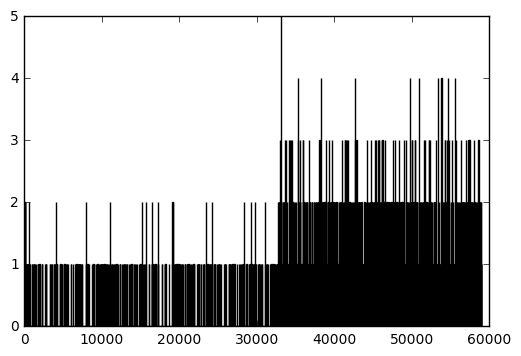

0.0

In [403]:
#NEED TO CLARIFY THIS PART

plt.hist(dfFinal['ROW_ID_x'] ,bins=5000)
# plt.title("Number of Counts for Patients")
# plt.xlabel("Patient's ID")
# plt.ylabel("Frequency")

plt.show()

In [416]:
dfFinal.duplicated('SUBJECT_ID').sum()

0

In [417]:
#selecting the relevant variables for logistic regression
dfFinal = dfFinal[['INSURANCE','LANGUAGE','RELIGION','MARITAL_STATUS','ETHNICITY','is_it_HAI_y']]

In [418]:
dfFinal.isnull().values.any()

False

In [419]:
#create dummy variables

dummy_insurance = pd.get_dummies(dfFinal['INSURANCE'], prefix='INSURANCE')
dummy_language = pd.get_dummies(dfFinal['LANGUAGE'], prefix = 'LANGUAGE')
dummy_religion = pd.get_dummies(dfFinal['RELIGION'], prefix = 'RELIGION')
dummy_maritalStatus = pd.get_dummies(dfFinal['MARITAL_STATUS'], prefix = 'MARITAL_STATUS')
dummy_ethnicity = pd.get_dummies(dfFinal['ETHNICITY'], prefix = 'ETHNICITY')


In [420]:
print(len(list(dummy_insurance.ix[:, 'INSURANCE_Medicaid':])) == len(list(dummy_insurance)) - 1)
print(len(list(dummy_language.ix[:, 'LANGUAGE_*AMH':])) == len(list(dummy_language)) - 1)
print(len(list(dummy_religion.ix[:, 'RELIGION_BAPTIST':])) == len(list(dummy_religion)) - 1)
print(len(list(dummy_maritalStatus.ix[:, 'MARITAL_STATUS_LIFE PARTNER':])) == len(list(dummy_maritalStatus)) - 1)
print(len(list(dummy_ethnicity.ix[:, 'ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE':])) == len(list(dummy_ethnicity)) - 1)

True
True
True
True
True


In [421]:
list(dummy_insurance.ix[:, 'INSURANCE_Medicaid':])

['INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay']

In [422]:
list(dummy_insurance)

['INSURANCE_Government',
 'INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay']

In [423]:
#create a new data frame to fit the dummy variables
colsToKeep = ['is_it_HAI_y']
data = dfFinal[colsToKeep].join(dummy_insurance.ix[:, 'INSURANCE_Medicaid':])
data = data.join(dummy_language.ix[:, 'LANGUAGE_*AMH':])
data = data.join(dummy_religion.ix[:, 'RELIGION_BAPTIST':])
data = data.join(dummy_maritalStatus.ix[:, 'MARITAL_STATUS_LIFE PARTNER':])
data = data.join(dummy_ethnicity.ix[:, 'ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE':])

In [424]:
#logistic regression

from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

train_cols = data.columns[1:]

logitModel = logistic.fit(data[train_cols], data['is_it_HAI_y'])

In [425]:
# examine 88 the coefficients(including intercept)

k=0
for i in train_cols:
    print(i, logitModel.coef_[0][k])
    k += 1
    

INSURANCE_Medicaid 0.00522809988187
INSURANCE_Medicare 0.169473296641
INSURANCE_Private -0.137575159239
INSURANCE_Self Pay -0.632111181432
LANGUAGE_*AMH -0.0417157303107
LANGUAGE_*ARM -0.206412156145
LANGUAGE_*BEN -0.0608391977724
LANGUAGE_*BUR -0.0468421456168
LANGUAGE_*CDI -0.10089128718
LANGUAGE_*FUL -0.0715525191102
LANGUAGE_*GUJ -0.0578767244192
LANGUAGE_*HUN -0.10089128718
LANGUAGE_*RUS -0.126577300148
LANGUAGE_*TOY 0.863297288223
LANGUAGE_*YID -0.14878651788
LANGUAGE_ALBA 0.867585624775
LANGUAGE_AMER 0.713249053253
LANGUAGE_CAMB -0.0892367357907
LANGUAGE_CANT 0.181114482159
LANGUAGE_CAPE -0.0355244412685
LANGUAGE_ENGL -0.37708599061
LANGUAGE_FREN -0.238244971865
LANGUAGE_GREE -0.591055075177
LANGUAGE_HAIT 0.264841908019
LANGUAGE_HIND -0.13160019232
LANGUAGE_ITAL -0.384983691994
LANGUAGE_JAPA -0.0450879520683
LANGUAGE_KORE -0.167545842962
LANGUAGE_LAOT -0.0698096501536
LANGUAGE_MAND -0.0849080780991
LANGUAGE_PERS 1.19173572096
LANGUAGE_POLI -0.166256322114
LANGUAGE_PORT -0.084330

In [426]:
#predict the training set accuracy rate

print("Training set accuracy rate", logitModel.score(data[train_cols], data['is_it_HAI_y']))


Training set accuracy rate 0.940087676571


In [427]:
#split into training and testing data set

split = np.random.rand(len(data)) < 0.5

test = data[split]

train = data[~split]


In [428]:
#training data

logitModel = logistic.fit(train[train_cols], train['is_it_HAI_y'])

#predict the training set accuracy rate

print("Training set accuracy rate", logitModel.score(train[train_cols], train['is_it_HAI_y']))

Training set accuracy rate 0.935211267606


In [429]:
def true_positive_rate(confusion_matrix):
    """ Find the true positive rate from the confusion matrix
    Parameters
    ----------
    confusion_matrix : 4 x 4 matrix with true positive, true negative, false positive, false negative

    Returns
    -------     
    float type, with true positive rate

    """
    
    true_positive = confusion_matrix[1][1]
    condition_positive = confusion_matrix[1][0] + confusion_matrix[1][1]
    
    return true_positive/condition_positive

def false_positive_rate(confusion_matrix):
    """ Find the false positive rate from the confusion matrix
    Parameters
    ----------
    confusion_matrix : 4 x 4 matrix with true positive, true negative, false positive, false negative

    Returns
    -------     
    float type, with false positive rate

    """
    
    false_positive = confusion_matrix[0][1]
    condition_positive = confusion_matrix[0][0] + confusion_matrix[0][1]
    
    return false_positive/condition_positive



In [430]:
from sklearn.metrics import confusion_matrix

confMatrix = confusion_matrix(train['is_it_HAI_y'], logitModel.predict(train[train_cols]))

true_positive_rate(confMatrix)
false_positive_rate(confMatrix)

0.0

In [431]:
#predict the test set accuracy rate

print("Testing set accuracy rate", logitModel.score(test[train_cols], test['is_it_HAI_y']))

Testing set accuracy rate 0.946356275304


In [432]:
from sklearn.metrics import confusion_matrix

confMatrix = confusion_matrix(test['is_it_HAI_y'], logitModel.predict(test[train_cols]))

true_positive_rate(confMatrix)
false_positive_rate(confMatrix)

0.0

# Preliminary Analysis

<img src="https://i.stack.imgur.com/CRZGo.png">

Since our testing set accuracy rate is higher than our training set, we can add more features to lower down the test and training error.

## ROC Curve

Need to check with professor regarding the optimal trade off point.

The issue here is that by identifying as many people from the HAI group(increasing true posiive rate), more health people will be incorrectly identified(increasing false positive rate). The trade off is that by increasing the true positive rate, we will also increase false positive rate(even though we want the false positive rate to go down). As such, the ROC curve will help us identify a sweet spot, an optimal point.



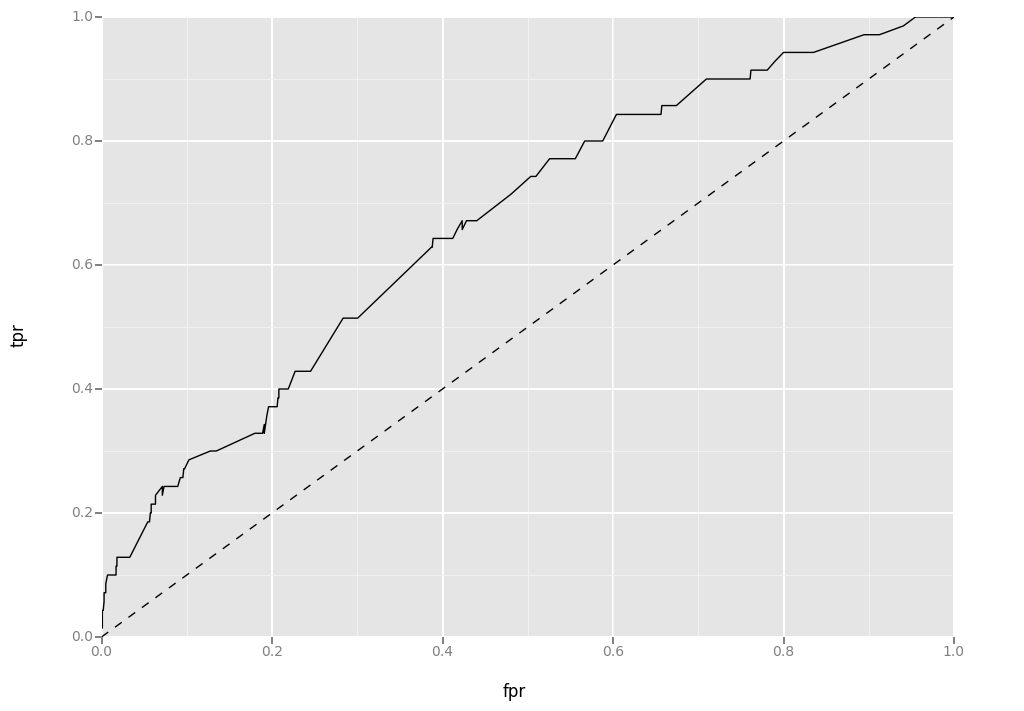

<ggplot: (295289927)>

In [433]:
from sklearn import metrics
from ggplot import *

preds = logitModel.predict_proba(train[train_cols])[:,1]
fpr, tpr, _ = metrics.roc_curve(train['is_it_HAI_y'], preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')


## Finding the optimal probability that corresponds to the sweet spot on the ROC curve

In [434]:
##Need to check the formula

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

# Add prediction probability to dataframe
train['pred_proba'] = preds

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(train['is_it_HAI_y'],  preds)
print("The cutoff probability is", threshold[0])
# [0.31762762459360921]

# Find prediction to the dataframe applying threshold
train['pred'] = train['pred_proba'].map(lambda x: 1 if x > float(threshold[0]) else 0)

# Print confusion Matrix
from sklearn.metrics import confusion_matrix

confMatrix = confusion_matrix(train['is_it_HAI_y'], train['pred'])
# array([[175,  98],
#        [ 46,  81]])

print("The true positive rate is", true_positive_rate(confMatrix))
print("The false positive rate is", false_positive_rate(confMatrix))

The cutoff probability is 0.0732781898241
The true positive rate is 0.514285714286
The false positive rate is 0.300502512563


/Users/tankaiwei/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tankaiwei/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Finding the sweet spot 

In [435]:
# Add prediction probability to dataframe
preds = logitModel.predict_proba(test[train_cols])[:,1]
test['pred_proba'] = preds

# Find prediction to the dataframe applying threshold
test['pred'] = test['pred_proba'].map(lambda x: 1 if x > float(0.0732781898241) else 0)

# Print confusion Matrix
from sklearn.metrics import confusion_matrix

confMatrix = confusion_matrix(test['is_it_HAI_y'], test['pred'])
# array([[175,  98],
#        [ 46,  81]])

print("The true positive rate is", true_positive_rate(confMatrix))
print("The false positive rate is", false_positive_rate(confMatrix))
print(true_positive_rate(confMatrix)/false_positive_rate(confMatrix))

The true positive rate is 0.339622641509
The false positive rate is 0.335828877005
1.01129671914


/Users/tankaiwei/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/tankaiwei/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Cost sensitive learning

In [491]:
#class weight say {0:.1, 1:.9}

#training data

logistic1 = LogisticRegression(class_weight= {1: 11.64})

logitModel1 = logistic1.fit(train[train_cols], train['is_it_HAI_y'])


In [493]:
confMatrix = confusion_matrix(train['is_it_HAI_y'], logitModel1.predict(train[train_cols]))

print("The true positive rate is", true_positive_rate(confMatrix), "The false positive rate is", false_positive_rate(confMatrix))

The true positive rate is 0.542857142857 The false positive rate is 0.298492462312


In [ ]:
confMatrix = confusion_matrix(train['is_it_HAI_y'], logitModel1.predict(train[train_cols]))

print("The true positive rate is", true_positive_rate(confMatrix), "The false positive rate is", false_positive_rate(confMatrix))

we can therefore use the above one which is ROC cuve

# Support Vector Machine linear

In [496]:
from sklearn import svm

In [504]:
clf = svm.SVC(kernel="linear") 
clf.fit(train[train_cols], train['is_it_HAI_y'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [507]:
confMatrix = confusion_matrix(train['is_it_HAI_y'], clf.predict(train[train_cols]))
print("The train true positive rate is", true_positive_rate(confMatrix), "The train false positive rate is", false_positive_rate(confMatrix))

The train true positive rate is 0.0428571428571 The train false positive rate is 0.0


In [508]:
confMatrix = confusion_matrix(test['is_it_HAI_y'], clf.predict(test[train_cols]))
print("The test true positive rate is", true_positive_rate(confMatrix), "The test false positive rate is", false_positive_rate(confMatrix))

The test true positive rate is 0.0 The test false positive rate is 0.0


# Support Vector Machine gaussian

In [509]:
clf = svm.SVC(kernel="rbf") 
clf.fit(train[train_cols], train['is_it_HAI_y'])
confMatrix = confusion_matrix(train['is_it_HAI_y'], clf.predict(train[train_cols]))
true_positive_rate(confMatrix)

0.0

In [510]:
confMatrix = confusion_matrix(train['is_it_HAI_y'], clf.predict(train[train_cols]))
print("The train true positive rate is", true_positive_rate(confMatrix), "The train false positive rate is", false_positive_rate(confMatrix))
confMatrix = confusion_matrix(test['is_it_HAI_y'], clf.predict(test[train_cols]))
print("The test true positive rate is", true_positive_rate(confMatrix), "The test false positive rate is", false_positive_rate(confMatrix))

The train true positive rate is 0.0 The train false positive rate is 0.0
The test true positive rate is 0.0 The test false positive rate is 0.0


# Support Vector Machine gaussian kernel with class weight

In [511]:
i = 0
true = np.zeros(10)
false = np.zeros(10)
 
while i < 10: 
    clf = svm.SVC(kernel="rbf", class_weight= {1:(12 + i)}) 
    clf.fit(train[train_cols], train['is_it_HAI_y'])
    confMatrix = confusion_matrix(train['is_it_HAI_y'], clf.predict(train[train_cols]))
    true[i] = true_positive_rate(confMatrix)
    false[i] = false_positive_rate(confMatrix)
    i = i + 1
    


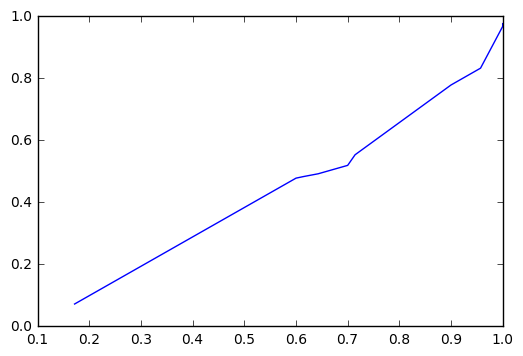

In [512]:
plt.figure()
plt.plot(true, false)
plt.show()

In [513]:
# find the points that is closest to (1,1)

dist = np.zeros(10)

i = 0
while i < 10:
    x_difference = (false[i] - 0)**2
    y_difference = (true[i] - 1)**2
    dist[i] = math.sqrt(x_difference + y_difference)
    i = i + 1

In [521]:
dist

array([ 0.83172522,  0.62358549,  0.61843964,  0.60833391,  0.59998506,
        0.62313128,  0.78528759,  0.83426736,  0.9678392 ,  0.97688442])

In [522]:
print(true[4], false[4])

0.7 0.51959798995


# Therefore, i will pick index 4 as my final model, the weight will be 16 for class 1 

In [523]:
clf = svm.SVC(kernel="rbf", class_weight= {1:16}) 
clf.fit(train[train_cols], train['is_it_HAI_y'])

SVC(C=1.0, cache_size=200, class_weight={1: 16}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [524]:
confMatrix = confusion_matrix(train['is_it_HAI_y'], clf.predict(train[train_cols]))
print("The train true positive rate is", true_positive_rate(confMatrix), "The train false positive rate is", false_positive_rate(confMatrix))
confMatrix = confusion_matrix(test['is_it_HAI_y'], clf.predict(test[train_cols]))
print("The test true positive rate is", true_positive_rate(confMatrix), "The test false positive rate is", false_positive_rate(confMatrix))

The train true positive rate is 0.7 The train false positive rate is 0.51959798995
The test true positive rate is 0.528301886792 The test false positive rate is 0.534759358289


# Support Vector Machine linear kernel with class weight

In [525]:
i = 0
true = np.zeros(10)
false = np.zeros(10)
 
while i < 10: 
    clf = svm.SVC(kernel="linear", class_weight= {1:(12 + i)}) 
    clf.fit(train[train_cols], train['is_it_HAI_y'])
    confMatrix = confusion_matrix(train['is_it_HAI_y'], clf.predict(train[train_cols]))
    true[i] = true_positive_rate(confMatrix)
    false[i] = false_positive_rate(confMatrix)
    i = i + 1
    

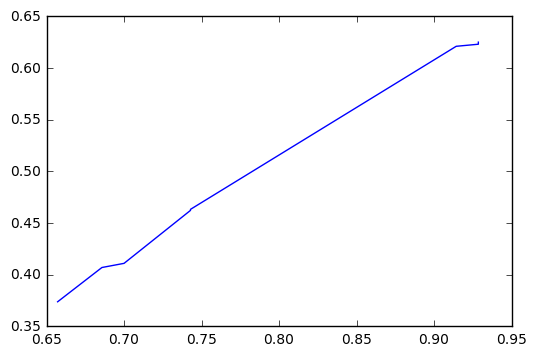

In [526]:
plt.figure()
plt.plot(true, false)
plt.show()

In [527]:
# find the points that is closest to (1,1)

dist = np.zeros(10)

i = 0
while i < 10:
    x_difference = (false[i] - 0)**2
    y_difference = (true[i] - 1)**2
    dist[i] = math.sqrt(x_difference + y_difference)
    i = i + 1


In [528]:
dist

array([ 0.50727636,  0.51425008,  0.50888745,  0.52901269,  0.52989122,
        0.62699204,  0.62719619,  0.62919321,  0.62919321,  0.62919321])

In [532]:
print(true[0], false[0])

0.657142857143 0.373869346734


# Therefore, i will pick index 0 as my final model, the weight will be 12 for class 1 

In [533]:
clf = svm.SVC(kernel="linear", class_weight= {1:12}) 
clf.fit(train[train_cols], train['is_it_HAI_y'])
confMatrix = confusion_matrix(train['is_it_HAI_y'], clf.predict(train[train_cols]))
print("The train true positive rate is", true_positive_rate(confMatrix), "The train false positive rate is", false_positive_rate(confMatrix))
confMatrix = confusion_matrix(test['is_it_HAI_y'], clf.predict(test[train_cols]))
print("The test true positive rate is", true_positive_rate(confMatrix), "The test false positive rate is", false_positive_rate(confMatrix))

The train true positive rate is 0.657142857143 The train false positive rate is 0.373869346734
The test true positive rate is 0.377358490566 The test false positive rate is 0.397860962567


# Random Forest

In [534]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

In [543]:
# Create a random forest classifier. By convention, clf means 'classifier'
clf = RandomForestClassifier()

# Train the classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(train[train_cols], train['is_it_HAI_y'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [544]:
confMatrix = confusion_matrix(train['is_it_HAI_y'], clf.predict(train[train_cols]))

#looking into the dist array, we find that the best performing metrics is when i is 9 with the following true positive 
# false positive rate

print("True Positive Rate", true_positive_rate(confMatrix), "False Positive Rate", false_positive_rate(confMatrix))

True Positive Rate 0.214285714286 False Positive Rate 0.00301507537688


In [545]:
confMatrix = confusion_matrix(test['is_it_HAI_y'], clf.predict(test[train_cols]))

#looking into the dist array, we find that the best performing metrics is when i is 9 with the following true positive 
# false positive rate

print("True Positive Rate", true_positive_rate(confMatrix), "False Positive Rate", false_positive_rate(confMatrix))

True Positive Rate 0.0188679245283 False Positive Rate 0.00320855614973


# Weighted Random Forest

In [538]:
#determine the best trade off of tpr and fpr 

count = 0
true = np.zeros(10)
false = np.zeros(10)
 

while count < 10:

    sample_weight = np.array([1 if i == 0 else 10 + count for i in train['is_it_HAI_y']])

    # Create a random forest classifier. By convention, clf means 'classifier'
    clf = RandomForestClassifier()

    # Train the classifier to take the training features and learn how they relate
    # to the training y (the species)
    clf.fit(train[train_cols], train['is_it_HAI_y'], sample_weight= sample_weight)

    confMatrix = confusion_matrix(train['is_it_HAI_y'], clf.predict(train[train_cols]))

    true[count] = true_positive_rate(confMatrix)

    false[count] = false_positive_rate(confMatrix)

    count = count + 1

In [539]:
# find the points that is closest to (1,1)

dist = np.zeros(10)

i = 0
while i < 10:
    x_difference = (false[i] - 0)**2
    y_difference = (true[i] - 1)**2
    dist[i] = math.sqrt(x_difference + y_difference)
    i = i + 1

In [540]:
dist

array([ 0.52561518,  0.40883985,  0.38494201,  0.36375019,  0.42226902,
        0.41301922,  0.39856803,  0.36020408,  0.38092344,  0.37781408])

In [541]:
print("True Positive Rate", true[7], "False Positive Rate", false[7])

True Positive Rate 0.771428571429 False Positive Rate 0.278391959799


# Therefore index 7 is the best, I will then pick 17 as the weight for the testing set

In [542]:
sample_weight = np.array([1 if i == 0 else 17 for i in train['is_it_HAI_y']])
clf = RandomForestClassifier()
clf.fit(train[train_cols], train['is_it_HAI_y'], sample_weight= sample_weight)
confMatrix = confusion_matrix(test['is_it_HAI_y'], clf.predict(test[train_cols]))

print("True Positive Rate", true_positive_rate(confMatrix), "False Positive Rate", false_positive_rate(confMatrix))

True Positive Rate 0.150943396226 False Positive Rate 0.259893048128
